# Customer outflow prediction

### Libraries upload

In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

## Data upload and preprocessing
- `contract.csv` — contract information;
- `personal.csv` — client information;
- `internet.csv` — information about internet services;
- `phone.csv` — information about phone services.

### Contract information

In [3]:
df_contract = pd.read_csv('datasets/final_provider/contract.csv')
display(df_contract.head())
df_contract.info()
print()
print('Duplicates:', df_contract.duplicated().sum())
print('NAs:', df_contract.isna().sum())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Duplicates: 0
NAs: customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [4]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d')
df_contract['EndDate'] = df_contract['EndDate'].replace('No', '2020-02-01')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format='%Y-%m-%d %H:%M:%S')

In [5]:
# Change data type in 'TotalCharges'
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')
df_contract[df_contract['TotalCharges'].isna()==True]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN


**CONCLUSION**

There is no data in "TotalCharges" for contracts, that were signed in data upload date. It is safer to delete these rows (11 rows).

In [6]:
df_contract = df_contract.dropna()
df_contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [7]:
# Calculate contract length 
df_contract['ContractLength'] = df_contract['EndDate'] - df_contract['BeginDate']
df_contract['ContractLength'] = (df_contract['ContractLength']/np.timedelta64(1, 'D')).astype(int)
display(df_contract.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractLength
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61


### Client information

In [8]:
df_personal = pd.read_csv('datasets/final_provider/personal.csv')
display(df_personal.head())
df_personal.info()
print()
print('Duplicates:', df_personal.duplicated().sum())
print('NAs:', df_personal.isna().sum())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Duplicates: 0
NAs: customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


### Internet servicies information

In [9]:
df_internet = pd.read_csv('datasets/final_provider/internet.csv')
display(df_internet.head())
df_internet.info()
print()
print('Duplicates:', df_internet.duplicated().sum())
print('NAs:', df_internet.isna().sum())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Duplicates: 0
NAs: customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


### Phone servicies information

In [10]:
df_phone = pd.read_csv('datasets/final_provider/phone.csv')
display(df_phone.head())
df_phone.info()
print()
print('Duplicates:', df_phone.duplicated().sum())
print('NAs:', df_phone.isna().sum())

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Duplicates: 0
NAs: customerID       0
MultipleLines    0
dtype: int64


## Dataframe merging

In [11]:
df = pd.merge(df_contract, df_personal, 
                      how='left', 
                      on='customerID')
df = pd.merge(df, df_internet, 
              how='left', 
              on='customerID')
df = pd.merge(df, df_phone, 
              how='left', 
              on='customerID')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   ContractLength    7032 non-null   int32         
 9   gender            7032 non-null   object        
 10  SeniorCitizen     7032 non-null   int64         
 11  Partner           7032 non-null   object        
 12  Dependents        7032 non-null   object        
 13  InternetService   5512 non-null   object        
 14  OnlineSecurity    5512 n

## Data preprocessing

In [13]:
display(df.head())
display(df.describe())
df.info()
print()
print('Duplicates:', df.duplicated().sum())
print('NAs:', df.isna().sum())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractLength,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,31,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,1036,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,1371,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


,MonthlyCharges,TotalCharges,ContractLength,SeniorCitizen
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,987.538538,0.162400
std,30.085974,2266.771362,747.153663,0.368844
min,18.250000,18.800000,30.000000,0.000000
25%,35.587500,401.450000,275.000000,0.000000
50%,70.350000,1397.475000,883.000000,0.000000
75%,89.862500,3794.737500,1676.000000,0.000000
max,118.750000,8684.800000,2191.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   ContractLength    7032 non-null   int32         
 9   gender            7032 non-null   object        
 10  SeniorCitizen     7032 non-null   int64         
 11  Partner           7032 non-null   object        
 12  Dependents        7032 non-null   object        
 13  InternetService   5512 non-null   object        
 14  OnlineSecurity    5512 n

### Omission fillings
If there are NAs in the data related to the Internet, then the user does not use it, and the same is true for telephony. We will not fill in the NAs - we will take them into account at the One Hot Encoding stage

### Data study

In [14]:
display(df.BeginDate.describe())
display(df.EndDate.describe())

<ipython-input-14-15b007106e2a>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.BeginDate.describe())


count                    7032
unique                     76
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-01-01 00:00:00
Name: BeginDate, dtype: object

<ipython-input-14-15b007106e2a>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.EndDate.describe())


count                    7032
unique                      5
top       2020-02-01 00:00:00
freq                     5163
first     2019-10-01 00:00:00
last      2020-02-01 00:00:00
Name: EndDate, dtype: object

The table contains data on concluded contracts for the period of 5 years and 4 months, and on terminated contracts - only for the last 4 months. Probably some data was lost.

In [15]:
columns = df.columns[3:20]
for col in columns:
    print('Value counts in ', col)
    print(df[col].value_counts())
    print('NAs', df[col].isna().sum())
    print()

Value counts in  Type
Month-to-month    3875
Two year          1685
One year          1472
Name: Type, dtype: int64
NAs 0

Value counts in  PaperlessBilling
Yes    4168
No     2864
Name: PaperlessBilling, dtype: int64
NAs 0

Value counts in  PaymentMethod
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64
NAs 0

Value counts in  MonthlyCharges
20.05    61
19.90    44
19.95    44
19.85    44
19.65    43
         ..
39.95     1
18.55     1
39.55     1
18.75     1
97.25     1
Name: MonthlyCharges, Length: 1584, dtype: int64
NAs 0

Value counts in  TotalCharges
20.20      11
19.75       9
20.05       8
19.65       8
19.90       8
           ..
6424.70     1
1474.35     1
6668.35     1
6096.90     1
5867.00     1
Name: TotalCharges, Length: 6530, dtype: int64
NAs 0

Value counts in  ContractLength
31      431
2191    362
30      182
92      169
2163    164
       ... 
1400 

The number of categories in each of the categorical features varies from 2 to 4, so you can use One Hot Encoder, which will slightly increase the number of features.

###  One Hot Encoding

In [16]:
df_ohe = pd.get_dummies(df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1), 
                        prefix=None, prefix_sep='_', 
                        columns=None, sparse=False, drop_first=True)

In [17]:
display(df_ohe)
display(df_ohe.info())

,MonthlyCharges,TotalCharges,ContractLength,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
0,29.85,29.85,31,0,0,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0
1,56.95,1889.50,1036,0,1,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
2,53.85,108.15,61,0,0,0,1,0,0,1,...,0,0,0,1,1,0,0,0,0,0
3,42.30,1840.75,1371,0,1,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
4,70.70,151.65,61,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,84.80,1990.50,730,0,1,0,1,0,0,1,...,1,1,0,1,0,1,1,1,1,1
7028,103.20,7362.90,2191,0,1,0,1,1,0,0,...,1,1,1,0,1,1,0,1,1,1
7029,29.60,346.45,337,0,0,0,1,0,1,0,...,1,1,0,1,0,0,0,0,0,0
7030,74.40,306.60,123,1,0,0,1,0,0,1,...,1,0,1,0,0,0,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         7032 non-null   float64
 1   TotalCharges                           7032 non-null   float64
 2   ContractLength                         7032 non-null   int32  
 3   SeniorCitizen                          7032 non-null   int64  
 4   Type_One year                          7032 non-null   uint8  
 5   Type_Two year                          7032 non-null   uint8  
 6   PaperlessBilling_Yes                   7032 non-null   uint8  
 7   PaymentMethod_Credit card (automatic)  7032 non-null   uint8  
 8   PaymentMethod_Electronic check         7032 non-null   uint8  
 9   PaymentMethod_Mailed check             7032 non-null   uint8  
 10  gender_Male                            7032 non-null   uint8  
 11  Part

None

### Correlation Heat Map

,MonthlyCharges,TotalCharges,ContractLength,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
MonthlyCharges,1.000000,0.651065,0.246715,0.219874,0.004810,-0.073256,0.351930,0.030055,0.271117,-0.376568,...,0.097825,-0.112343,0.787195,0.296447,0.441529,0.482607,0.338301,0.629668,0.627235,0.490912
TotalCharges,0.651065,1.000000,0.825811,0.102411,0.170569,0.358036,0.157830,0.182663,-0.060436,-0.294708,...,0.319072,0.064653,0.360769,0.412619,0.510100,0.522881,0.432868,0.515709,0.519867,0.469042
ContractLength,0.246715,0.825811,1.000000,0.015630,0.202418,0.563814,0.004729,0.232827,-0.210301,-0.232083,...,0.381924,0.163442,0.017782,0.328299,0.361100,0.361469,0.325307,0.280165,0.285298,0.332292
SeniorCitizen,0.219874,0.102411,0.015630,1.000000,-0.046491,-0.116205,0.156258,-0.024359,0.171322,-0.152987,...,0.016957,-0.210550,0.254923,-0.038576,0.066663,0.059514,-0.060577,0.105445,0.119842,0.142996
Type_One year,0.004810,0.170569,0.202418,-0.046491,1.000000,-0.288843,-0.052278,0.067590,-0.109546,0.000197,...,0.083067,0.069222,-0.076809,0.100658,0.084113,0.102911,0.096258,0.061930,0.064780,-0.003594
Type_Two year,-0.073256,0.358036,0.563814,-0.116205,-0.288843,1.000000,-0.146281,0.174410,-0.281147,-0.007423,...,0.247334,0.201699,-0.209965,0.191698,0.111391,0.165248,0.240924,0.072124,0.075603,0.106618
PaperlessBilling_Yes,0.351930,0.157830,0.004729,0.156258,-0.052278,-0.146281,1.000000,-0.013726,0.208427,-0.203981,...,-0.013957,-0.110131,0.326470,-0.004051,0.127056,0.104079,0.037536,0.224241,0.211583,0.163746
PaymentMethod_Credit card (automatic),0.030055,0.182663,0.232827,-0.024359,0.067590,0.174410,-0.013726,1.000000,-0.373978,-0.285583,...,0.082327,0.061134,-0.050552,0.115473,0.090455,0.111252,0.117024,0.040010,0.048398,0.060319
PaymentMethod_Electronic check,0.271117,-0.060436,-0.210301,0.171322,-0.109546,-0.281147,0.208427,-0.373978,1.000000,-0.386971,...,-0.083207,-0.149274,0.335763,-0.112295,-0.000364,-0.003308,-0.114807,0.144747,0.137420,0.083583
PaymentMethod_Mailed check,-0.376568,-0.294708,-0.232083,-0.152987,0.000197,-0.007423,-0.203981,-0.285583,-0.386971,1.000000,...,-0.096948,0.056448,-0.305984,-0.079918,-0.174075,-0.187325,-0.084631,-0.247712,-0.250290,-0.227672


<AxesSubplot:>

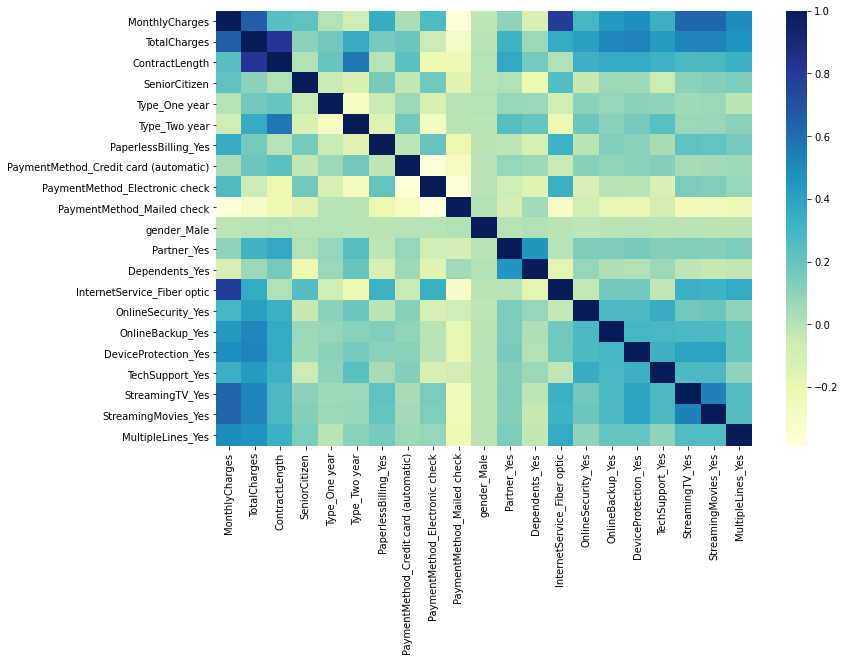

In [18]:
display(df_ohe.corr())
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df_ohe.corr(), cmap="YlGnBu", ax=ax)

**Conclusions**

On the feature correlation heatmap, you can see a high correlation (>0.65) between MonthlyCharges and TotalCharges, ContractLength and TotalCharges, which is logical, the longer the contract is and the higher the monthly payments, the higher the total amount of paid services.

### Target

In [19]:
# Find closed contracts
df_ohe['target'] = df['EndDate']!='2020-02-01'
display(df_ohe['target'].value_counts())
print('Rate of closed contracts:', df_ohe.target.mean())

False    5163
True     1869
Name: target, dtype: int64

Rate of closed contracts: 0.26578498293515357


## Models

In [20]:
# Train Test split
X = df_ohe.drop('target', 1)
y = df_ohe.target

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

### Logistic Regression

In [21]:
%%time
lr = LogisticRegression(solver='liblinear', penalty='l1', class_weight='balanced', verbose=False)
lr.fit(X_train, y_train)

Wall time: 58.8 ms


LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear',
                   verbose=False)

In [22]:
print('ROC-AUC on test sample', roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))

ROC-AUC on test sample 0.8253749268782582


 ### Random Forest

In [23]:
%%time
parameters = {
    'n_estimators': (100, 400, 800),
    'max_depth': [3, 4, 5, 6, 7, 8]
}

rf = RandomForestClassifier(class_weight='balanced', verbose=False)
rfc = GridSearchCV(rf, parameters, scoring='roc_auc', cv=3)
rfc.fit(X_train, y_train)

Wall time: 1min


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              verbose=False),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'n_estimators': (100, 400, 800)},
             scoring='roc_auc')

In [24]:
rfc.best_score_

0.8624697525975605

In [25]:
rfc.best_params_

{'max_depth': 8, 'n_estimators': 400}

In [26]:
print('ROC-AUC on test sample',roc_auc_score(y_test, rfc.best_estimator_.predict_proba(X_test)[:, 1]))

ROC-AUC on test sample 0.8438352547742674


### Catboost

In [27]:
%%time
parameters = {
    'n_estimators': (400, 800), 
    'learning_rate': [0.1],
    'max_depth': [3, 4]
}
cbc = CatBoostClassifier(verbose=False)
clf = GridSearchCV(cbc, parameters, scoring='roc_auc', cv=3)
clf.fit(X_train, y_train)

Wall time: 22.6 s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000018A0D2E0610>,
             param_grid={'learning_rate': [0.1], 'max_depth': [3, 4],
                         'n_estimators': (400, 800)},
             scoring='roc_auc')

In [28]:
clf.best_score_

0.9168793505086388

In [29]:
clf.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 800}

In [30]:
print('ROC-AUC on test sample',roc_auc_score(y_test, clf.best_estimator_.predict_proba(X_test)[:, 1]))

ROC-AUC on test sample 0.9074136386931785


**Conclusions**

Three models were built on the features (Logistic Regression, Random Forest, CatBoost) and hyperparameters were selected for each of them. The highest ROC-AUC value (0.91) was obtained using Catbooost with the following parameters: 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 800. Now we need to find the optimal threshold value, and also exclude "unimportant" parameters.

### Delete features with minimal importances

In [31]:
clf.best_estimator_.feature_importances_

array([ 8.77440711,  6.26916052, 66.19150388,  0.56431265,  1.65147318,
        5.01884512,  0.49250656,  0.19249409,  1.30773156,  0.62431676,
        0.6048994 ,  0.18072993,  0.4355253 ,  4.15794198,  0.62201126,
        0.14878043,  0.07707368,  0.61729659,  0.73218446,  0.87982497,
        0.45698055])

<AxesSubplot:ylabel='feature_names'>

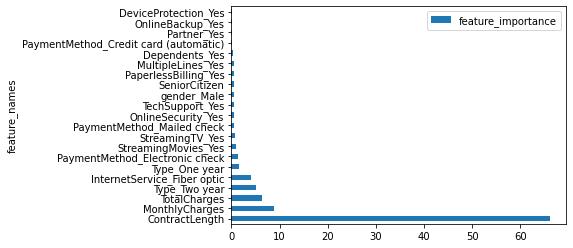

In [32]:
fig = pd.DataFrame({'feature_importance': clf.best_estimator_.feature_importances_, 
              'feature_names': X.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)
fig.plot.barh(x='feature_names', y='feature_importance')

In [33]:
# Delete features with minimal importamces (leave features with feature_importence > 1), 
# And delete 'TotalCharges', because it depends on ContractLength и MonthlyCharges
X_imp = X[['MonthlyCharges',  'ContractLength',
       'Type_One year', 'Type_Two year', 'PaymentMethod_Electronic check',  
        'InternetService_Fiber optic', 'StreamingMovies_Yes']]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X_imp, 
    y, 
    test_size=0.2, 
    random_state=42
)

In [35]:
%%time
parameters = {
    'n_estimators': (400, 800), 
    'learning_rate': [0.1],
    'max_depth': [3, 4]
}
cbc = CatBoostClassifier(verbose=False)
clf = GridSearchCV(cbc, parameters, scoring='roc_auc', cv=3)
clf.fit(X_train, y_train)

Wall time: 22.7 s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000018A0D251B20>,
             param_grid={'learning_rate': [0.1], 'max_depth': [3, 4],
                         'n_estimators': (400, 800)},
             scoring='roc_auc')

In [36]:
print('Best value of ROC-AUC', clf.best_score_)

Best value of ROC-AUC 0.9328284217536146


In [37]:
clf.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 800}

In [38]:
roc_auc_score(y_test, clf.best_estimator_.predict_proba(X_test)[:, 1])

0.9212097053905607

When deleted 13 features of 21 we have slightly improved the model (ROC-AUC increased from  с 0,91 to 0,921)

### Selection of the optimal threshold for catboost

In [39]:
%%time
predict = clf.best_estimator_.predict_proba(X_train)[:, 1]
best_thres = 0.01
max_accur_score = 0
for i in range(1, 100):
    thres = i / 100
    var = accuracy_score(y_train, list(map(int, predict > thres)))
    if var > max_accur_score:
        max_accur_score = var
        best_thres = thres

Wall time: 308 ms


In [40]:
print('Best accuracy score', max_accur_score, 'with threshold', best_thres)

Best accuracy score 0.9358222222222222 with threshold 0.42


## Conclusion

The problem is to predict customer outflow of telecom company, i.e. find those who are most likely to close the contract. This is a classification problem. The target is the fact of closing the contract.

The initial data contained information on contracts concluded within 5 years, but the data on terminated contracts cover the period of the last 4 months only. To improve the forecast, we recommend adding information on previously closed contracts.

Based on information about 7043 contracts, we built models that predict which contracts are likely to be closed so that the company has a chance to prevent this. We compared LogisticRegression, RandomForestClassifier and CatBoost models. A higher value of the AUC-ROC metric (0.921) was achieved using the CatBoost model with the exclusion of a number of features.

The optimal threshold value threshold=0.42 was found to achieve the maximum value of the accuracy metric.